In [2]:
import logging

In [3]:
import pandas as pd
import numpy as np

In [4]:
import dowhy
from dowhy import CausalModel

In [5]:
from IPython.display import Image, display

In [6]:
pd.set_option("mode.chained_assignment", None)

In [7]:
from futil import * 

## Initial setup: load in the WDI, project data, etc

In [8]:
wdi_df, series_df = load_wdi()

In [9]:
gdp_per_cap_code = ['NY.GDP.PCAP.KD.ZG']
gdp_growth_series = extract_indicators(wdi_df, gdp_per_cap_code)

In [10]:
project_df = load_projects()

In [11]:
project_df.donor_name.value_counts()

WB         7146
KfW        2229
DFID       1917
AsianDB    1572
JICA        723
GFATM       581
GiZ         129
IFAD         55
Name: donor_name, dtype: int64

In [12]:
wb_pdf = project_df[project_df.donor_name == 'WB']
print("Number WB projects with clean match to WDI country code: ", len(wb_pdf[wb_pdf.country_code.isin(gdp_growth_series['Country Code'])]))

Number WB projects with clean match to WDI country code:  3681


In [63]:
df = wb_pdf[wb_pdf.country_code.isin(gdp_growth_series['Country Code'])]

In [64]:
relevant_cols_from_project_df = [
 'wb_project_id', 
 'country_code',
 'six_overall_rating', 
 'wb_government_partner_rating', 
 'eval_lag', 
 'project_duration',
 'project_name',
 'original_overall_rating',
 'wb_lendingproject_cost',
 'wb_lendinginstrumenttype',
 'wb_qualityatentry_rating',
 'wb_supervisionquality_rating',
 'wb_owninstperformance_rating',
 'start_date',
 'completion_date',
 'evaluation_date'
]

In [65]:
df = narrow_convert_project_data(df, relevant_cols_from_project_df)

In [66]:
gdp_series = extract_indicators(wdi_df, ['NY.GDP.MKTP.CD'])

In [69]:
def proj_share_gdp(project):
    gdp_for_country = gdp_series[gdp_series['Country Code'] == project['country_code']]
    if str(project['start_year']) not in gdp_for_country.columns:
        project['gdp_cusd_year'] = np.nan
        project['proj_share_gdp'] = np.nan
        return project
    
    gdp_cusd_year = gdp_for_country[str(project['start_year'])].iloc[0]
    project['gdp_cusd_year'] = gdp_cusd_year
    project['proj_share_gdp'] = project['wb_lendingproject_cost'] / gdp_cusd_year
    return project

In [70]:
df = df.apply(proj_share_gdp, axis=1)

In [71]:
df.head()

,wb_project_id,country_code,six_overall_rating,wb_government_partner_rating,eval_lag,project_duration,project_name,original_overall_rating,wb_lendingproject_cost,wb_lendinginstrumenttype,...,wb_owninstperformance_rating,start_date,completion_date,evaluation_date,start_dt,start_year,completion_dt,end_year,gdp_cusd_year,proj_share_gdp
6496,P057271,GUY,5.0,5.0,365.0,1095.0,Emergency Assistance Project,5.0,10200000.0,ERL,...,5.0,01jan1999,01jan2002,01jan2003,1999-01-01,1999,2002-01-01,2002.0,6.947550e+08,0.014681
6497,P009674,IND,5.0,NaN,1460.0,2555.0,(DFC) IDBI I,5.0,0.0,FIL,...,NaN,01sep1973,01jan1980,01jan1984,1973-09-01,1973,1980-01-01,1980.0,8.551527e+10,0.000000
6498,P102095,COL,6.0,6.0,730.0,730.0,(LKD) GPOBA W3: Colombia Natural Gas,6.0,5085000.0,SIL,...,5.0,01jan2006,01jan2008,01jan2010,2006-01-01,2006,2008-01-01,2008.0,1.616186e+11,0.000031
6500,P043871,BRA,5.0,5.0,365.0,1825.0,(PIAUI)R.POVERTY,5.0,40000000.0,SIL,...,5.0,12dec1996,01jan2002,01jan2003,1996-12-12,1996,2002-01-01,2002.0,8.504264e+11,0.000047
6502,P010415,PAK,5.0,5.0,365.0,1825.0,1992 FLOOD DAMAGE RE,5.0,397200000.0,ERL,...,5.0,03apr1993,01jan1998,01jan1999,1993-04-03,1993,1998-01-01,1998.0,5.180995e+10,0.007666


<AxesSubplot:>

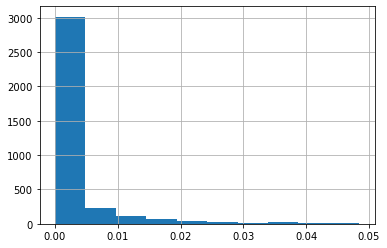

In [73]:
df[df.proj_share_gdp < 0.05].proj_share_gdp.hist()

In [74]:
df[df.proj_share_gdp > 0.1]

,wb_project_id,country_code,six_overall_rating,wb_government_partner_rating,eval_lag,project_duration,project_name,original_overall_rating,wb_lendingproject_cost,wb_lendinginstrumenttype,...,wb_owninstperformance_rating,start_date,completion_date,evaluation_date,start_dt,start_year,completion_dt,end_year,gdp_cusd_year,proj_share_gdp
7763,P004809,TON,2.0,2.0,1460.0,2190.0,DEVELOPMENT BANK II,2.0,1.530000e+07,FIL,...,2.0,01apr1990,01jan1996,01jan2000,1990-04-01,1990,1996-01-01,1996.0,1.135638e+08,0.134726
8361,P004863,WSM,5.0,5.0,365.0,2920.0,EMERGENCY ROAD REHAB,5.0,2.120000e+07,ERL,...,6.0,01jan1990,01jan1998,01jan1999,1990-01-01,1990,1998-01-01,1998.0,1.257663e+08,0.168567
8472,P044674,ERI,5.0,5.0,730.0,1460.0,ER-Emerg Reconstr ERL (FY01),5.0,2.927000e+08,ERL,...,5.0,01jan2001,01jan2005,01jan2007,2001-01-01,2001,2005-01-01,2005.0,7.523685e+08,0.389038
8553,P040650,MLI,4.0,4.0,365.0,2190.0,Edu Sec Exp Prgm APL (FY01) - (PISE),4.0,5.412000e+08,APL,...,5.0,01jan2001,01jan2007,01jan2008,2001-01-01,2001,2007-01-01,2007.0,3.465306e+09,0.156177
8932,P073649,GHA,3.0,3.0,365.0,1460.0,GH-Health Sec Prgm Supt 2 (FY03),3.0,1.113000e+09,SIL,...,3.0,02jun2003,01jan2007,01jan2008,2003-06-02,2003,2007-01-01,2007.0,7.632407e+09,0.145826
8940,P050623,GHA,5.0,5.0,365.0,2190.0,GH-Road Sec Dev Project (FY02),5.0,1.191000e+09,SIL,...,5.0,01jan2002,01jan2008,01jan2009,2002-01-01,2002,2008-01-01,2008.0,6.166330e+09,0.193146
9021,P035688,GNB,3.0,2.0,365.0,3650.0,GW-National Health Dev. Prog. (FY98),3.0,6.610000e+07,SIL,...,4.0,01jan1998,01jan2008,01jan2009,1998-01-01,1998,2008-01-01,2008.0,2.064575e+08,0.320163
10129,P102915,LBR,5.0,5.0,365.0,0.0,LR-Re-eng. and Reform Support (DPO),5.0,4.300000e+08,DPL,...,5.0,12apr2007,01jan2008,01jan2009,2007-04-12,2007,2008-01-01,2008.0,1.373000e+09,0.313183
10327,P001730,MLI,4.0,5.0,365.0,4015.0,ML TRANSPORT SECTOR,4.0,3.057000e+08,SIL,...,5.0,01jan1994,01jan2005,01jan2006,1994-01-01,1994,2005-01-01,2005.0,2.081846e+09,0.146841
12495,P047319,SEN,4.0,5.0,365.0,2190.0,SN-Quality Edu For All (FY00),4.0,9.260000e+08,APL,...,5.0,04nov2000,01jan2006,01jan2007,2000-11-04,2000,2006-01-01,2006.0,5.924240e+09,0.156307


## Extract indicator averages before, during and after projects (will automate to allow walking over lags)

In [17]:
df = df.apply(lambda project: extract_indicator_pre_during_post(project, "growth", gdp_growth_series), axis=1)

<AxesSubplot:>

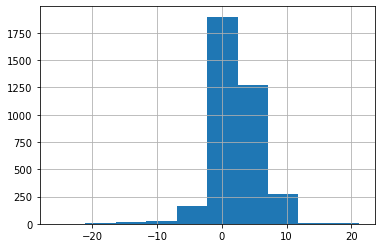

In [18]:
df.growth_prior.hist()

<AxesSubplot:>

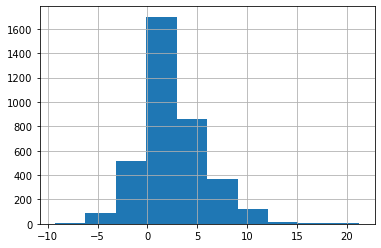

In [19]:
df.growth_during.hist()

<AxesSubplot:>

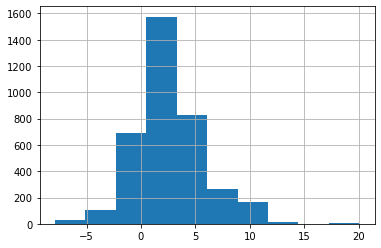

In [20]:
df.growth_post.hist()

In [21]:
df.growth_during.describe()

count    3676.000000
mean        2.483981
std         3.188126
min        -9.276867
25%         0.481342
50%         2.096917
75%         3.876678
max        21.244872
Name: growth_during, dtype: float64

In [22]:
df.growth_post.describe()

count    3676.000000
mean        2.634407
std         3.163606
min        -7.905942
25%         0.615209
50%         2.394937
75%         4.031064
max        20.060154
Name: growth_post, dtype: float64

## Initial causal runs

In [23]:
rating_growth_graph = """digraph { 
    "Govt-Quality"[latent];
    six_overall_rating [exposure, label="WB-Loan-Rating"];
    global_growth_during [adjusted, label="GlobalMacroDuringProject"];
    global_growth_post [label="GlobalMacroPostProject"];
    global_growth_prior [adjusted, label="GlobalMacroPriorProject"];
    growth_during [adjusted, label=GrowthDuringProject];
    growth_post [outcome, label=GrowthPostProject];
    growth_prior [adjusted, label=GrowthPriorProject];
    wb_government_partner_rating [label="WBGovtRating"];
    "Govt-Quality" -> six_overall_rating;
    "Govt-Quality" -> growth_prior;
    "Govt-Quality" -> wb_government_partner_rating;
    six_overall_rating -> growth_post;
    global_growth_during -> global_growth_post;
    global_growth_during -> growth_during;
    global_growth_post -> growth_post;
    global_growth_prior -> global_growth_during;
    global_growth_prior -> growth_prior;
    growth_during -> growth_post;
    growth_prior -> growth_during;
    wb_government_partner_rating -> six_overall_rating;
    }"""

In [24]:
causal_columns = ['six_overall_rating', 'global_growth_prior', 'global_growth_during', 'global_growth_post',
                 'growth_prior', 'growth_during', 'growth_post', 'wb_government_partner_rating']

In [25]:
def perform_causal_estimate(df, num_years_post, verbose=False):
    extract_ind = lambda project: extract_indicator_pre_during_post(project, "growth", gdp_growth_series, num_years=num_years_post)
    df = df.apply(extract_ind, axis=1)
    causal_df = df[causal_columns]
    pre_drop_N = len(causal_df)
    causal_df = causal_df.dropna()
    post_drop_N = len(causal_df)
    if verbose:
        print("N pre NA drop: ", pre_drop_N, " and post: ", post_drop_N)
    
    model = CausalModel(
        data=causal_df,
        graph=rating_growth_graph.replace("\n", " "),
        treatment="six_overall_rating",
        outcome="growth_post"
    )
    
    if verbose:
        model.view_model()
        display(Image(filename="causal_model.png"))
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    if verbose:
        print(identified_estimand)
    
    estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression",
                                     target_units="att", test_significance=True)
    if verbose:
        print(estimate)
    
    return {"model": model, "estimand": identified_estimand, "estimate": estimate}

In [26]:
result = perform_causal_estimate(df, num_years_post=5)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. Invalid Input
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['six_overall_rating'] on outcome ['growth_post']
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: growth_post~six_overall_rating+growth_during+global_growth_post+global_growth_during+global_growth_prior+wb_government_partner_rating+growth_prior+six_overall_rating*growth_during+six_overall_rating*global_growth_post+six_overall_rating*global_growth_during+six_overall_rating*global_growth_prior+six_overall_rating*growth_prior
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


In [27]:
print(result["estimate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: growth_post~six_overall_rating+growth_during+global_growth_post+global_growth_during+global_growth_prior+wb_government_partner_rating+growth_prior+six_overall_rating*growth_during+six_overall_rating*global_growth_post+six_overall_rating*global_growth_during+six_overall_rating*global_growth_prior+six_overall_rating*growth_prior
Target units: att

## Estimate
Mean value: -0.005914790734909747
p-value: [0.12426414]
### Conditional Estimates
__categorical__growth_during  __categorical__global_growth_post  __categorical__global_growth_during  __categorical__global_growth_prior  __categorical__growth_prior
(-9.277999999999999, 0.688]   (0.456, 1.305]                     (0.456, 1.161]                       (0.595, 1.369]                      (0.0, 1.52]                    0.158736
                                                                                                      (1.626

In [30]:
estimate = result["estimate"]
estimate.value

In [31]:
estimate.test_stat_significance()['p_value'][0]

## Now initiate exploration of different lag settings

In [32]:
def crawl_over_lags(range_of_years):
    model_results = [perform_causal_estimate(df, num_years_post=num_years_post) for num_years_post in range_of_years]
    return dict(zip(range_of_years, model_results))

In [33]:
test_results = perform_causal_estimate(df, num_years_post=10)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. Invalid Input
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['six_overall_rating'] on outcome ['growth_post']
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: growth_post~six_overall_rating+growth_during+global_growth_post+global_growth_during+global_growth_prior+wb_government_partner_rating+growth_prior+six_overall_rating*growth_during+six_overall_rating*global_growth_post+six_overall_rating*global_growth_during+six_overall_rating*global_growth_prior+six_overall_rating*growth_prior
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


In [34]:
estimate = test_results["estimate"]

In [35]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: growth_post~six_overall_rating+growth_during+global_growth_post+global_growth_during+global_growth_prior+wb_government_partner_rating+growth_prior+six_overall_rating*growth_during+six_overall_rating*global_growth_post+six_overall_rating*global_growth_during+six_overall_rating*global_growth_prior+six_overall_rating*growth_prior
Target units: att

## Estimate
Mean value: 0.0031933162821853323
p-value: [0.61952926]
### Conditional Estimates
__categorical__growth_during  __categorical__global_growth_post  __categorical__global_growth_during  __categorical__global_growth_prior  __categorical__growth_prior
(-9.277999999999999, 0.688]   (1.096, 1.503]                     (0.456, 1.161]                       (1.421, 2.239]                      (1.028, 1.882]                 0.035675
                                                                                                            

In [36]:
range_results = crawl_over_lags(range(1, 11))

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. Invalid Input
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['six_overall_rating'] on outcome ['growth_post']
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: growth_post~six_overall_rating+growth_during+global_growth_post+global_growth_during+global_growth_prior+wb_government_partner_rating+growth_prior+six_overall_rating*growth_during+six_overall_rating*global_growth_post+six_overall_rating*global_growth_during+six_overall_rating*global_growth_prior+six_overall_rating*growth_prior
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. Invalid Input
Trying pydot ...
INFO:dowhy.causa

KeyboardInterrupt: 

In [ ]:
extract_coeff_and_p = lambda year, result: { 
    "years_after": year, 
    "ate": result["estimate"].value,
    "pval": result["estimate"].test_stat_significance()['p_value'][0]
}

In [ ]:
extract_coeff_and_p(1, range_results[1])

In [ ]:
result_table = pd.DataFrame([extract_coeff_and_p(year, result) for year, result in range_results.items()])

In [ ]:
result_table

In [ ]:
result_table.to_csv('../data/results/initial_growth_crawl.csv', index=False)

## Adding in project size relative to gdp

In [37]:
gdp_series = extract_indicators(wdi_df, ['NY.GDP.MKTP.CD'])

In [38]:
gdp_series.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
466,Arab World,ARB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.773499e+12,2.856372e+12,2.894391e+12,2.534724e+12,2.469440e+12,2.516121e+12,2.771384e+12,2.817415e+12,NaN,NaN
1901,Caribbean small states,CSS,GDP (current US$),NY.GDP.MKTP.CD,1.880306e+09,2.038302e+09,2.153896e+09,2.290314e+09,2.470265e+09,2.660946e+09,...,7.205112e+10,7.341759e+10,7.443367e+10,7.282847e+10,6.919134e+10,7.145256e+10,7.496727e+10,7.772171e+10,NaN,NaN
3336,Central Europe and the Baltics,CEB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.352689e+12,1.422194e+12,1.464900e+12,1.292087e+12,1.320631e+12,1.463498e+12,1.644436e+12,1.668852e+12,NaN,NaN
4771,Early-demographic dividend,EAR,GDP (current US$),NY.GDP.MKTP.CD,1.517106e+11,1.528336e+11,1.586219e+11,1.681859e+11,1.930554e+11,2.093716e+11,...,1.008164e+13,1.025981e+13,1.062047e+13,1.031164e+13,1.055044e+13,1.139972e+13,1.164598e+13,1.198987e+13,NaN,NaN
6206,East Asia & Pacific,EAS,GDP (current US$),NY.GDP.MKTP.CD,1.532581e+11,1.537058e+11,1.572680e+11,1.754950e+11,2.016310e+11,2.245756e+11,...,2.107208e+13,2.131856e+13,2.200218e+13,2.191164e+13,2.265859e+13,2.422269e+13,2.635135e+13,2.692466e+13,NaN,NaN


In [42]:
project = df.iloc[0].to_dict()

In [43]:
project

{'wb_project_id': 'P057271',
 'country_code': 'GUY',
 'six_overall_rating': 5.0,
 'wb_government_partner_rating': 5.0,
 'eval_lag': 365.0,
 'project_duration': 1095.0,
 'project_name': ' Emergency Assistance Project',
 'original_overall_rating': 5.0,
 'wb_lendingproject_cost': 10200000.0,
 'wb_lendinginstrumenttype': 'ERL',
 'wb_qualityatentry_rating': 5.0,
 'wb_supervisionquality_rating': 5.0,
 'wb_owninstperformance_rating': 5.0,
 'start_date': '01jan1999',
 'completion_date': '01jan2002',
 'evaluation_date': '01jan2003',
 'start_dt': Timestamp('1999-01-01 00:00:00'),
 'start_year': 1999,
 'completion_dt': Timestamp('2002-01-01 00:00:00'),
 'end_year': 2002.0,
 'growth_prior': 5.204767829212794,
 'global_growth_prior': 1.60503590038959,
 'growth_during': 0.7011928383593666,
 'global_growth_during': 1.8744232982929852,
 'growth_post': 2.2145603861732424,
 'global_growth_post': 2.715864689653008}

In [45]:
gdp_for_country = gdp_series[gdp_series['Country Code'] == project['country_code']]

In [46]:
gdp_for_country

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
187016,Guyana,GUY,GDP (current US$),NY.GDP.MKTP.CD,1.702152e+08,1.858485e+08,1.949484e+08,1.757569e+08,1.947734e+08,2.132353e+08,...,4.063090e+09,4.167802e+09,4.127664e+09,4.279840e+09,4.482697e+09,4.748174e+09,4.787636e+09,5.173760e+09,NaN,NaN


In [59]:
def proj_share_gdp(project, gdp_series):
    gdp_for_country = gdp_series[gdp_series['Country Code'] == project['country_code']]
    if str(project['start_year']) not in gdp_for_country.columns:
        project['gdp_cusd_year'] = np.nan
        project['proj_share_gdp'] = np.nan
        return project
    
    gdp_cusd_year = gdp_for_country[str(project['start_year'])].iloc[0]
    project['gdp_cusd_year'] = gdp_cusd_year
    project['proj_share_gdp'] = project['wb_lendingproject_cost'] / gdp_cusd_year
    return project

In [60]:
proj_share_gdp(project)

{'wb_project_id': 'P057271',
 'country_code': 'GUY',
 'six_overall_rating': 5.0,
 'wb_government_partner_rating': 5.0,
 'eval_lag': 365.0,
 'project_duration': 1095.0,
 'project_name': ' Emergency Assistance Project',
 'original_overall_rating': 5.0,
 'wb_lendingproject_cost': 10200000.0,
 'wb_lendinginstrumenttype': 'ERL',
 'wb_qualityatentry_rating': 5.0,
 'wb_supervisionquality_rating': 5.0,
 'wb_owninstperformance_rating': 5.0,
 'start_date': '01jan1999',
 'completion_date': '01jan2002',
 'evaluation_date': '01jan2003',
 'start_dt': Timestamp('1999-01-01 00:00:00'),
 'start_year': 1999,
 'completion_dt': Timestamp('2002-01-01 00:00:00'),
 'end_year': 2002.0,
 'growth_prior': 5.204767829212794,
 'global_growth_prior': 1.60503590038959,
 'growth_during': 0.7011928383593666,
 'global_growth_during': 1.8744232982929852,
 'growth_post': 2.2145603861732424,
 'global_growth_post': 2.715864689653008,
 'gdp_cusd_year': 694754988.258295,
 'proj_share_gdp': 0.014681434710631913}

In [61]:
df = df.apply(proj_share_gdp, axis=1)

<AxesSubplot:>

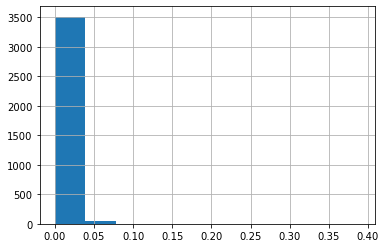

In [62]:
df.proj_share_gdp.hist()